In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
import matplotlib.patches as mpatches
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import os
import warnings
import itertools
import numpy as np
import pandas as pd
from scipy import stats
# local import
from utils import read_mi, enrichment
from utils import ml_metrics, get_rbd_mutated
from utils import AFFINITY, ESCAPE, MOI

In [3]:
INTERESTING = set(MOI).union(AFFINITY).union(ESCAPE)

In [4]:
print(INTERESTING)

{18, 403, 406, 417, 681, 439, 440, 446, 447, 449, 452, 455, 456, 477, 484, 489, 493, 494, 496, 498, 501, 505, 506}


In [5]:
df = []
d_mutated = {}
all_mutated = set()
for name in sorted(os.listdir('../out/time-filtered-subsets/')):
    try:
        df.append(read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated_prefilter.tsv.gz',
                          name,
                          date=True))
        mutated = get_rbd_mutated('../out/time-filtered-lineages/',
                                  names=[name,])
        d_mutated[name] = mutated.union(all_mutated)
        all_mutated = mutated.union(all_mutated)
    except FileNotFoundError:
        pass
df = pd.concat(df)

/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')


In [6]:
df.groupby(['year', 'month'])['pos_source'].count()

year  month
2020  3        422192
      4        324154
      5        476866
      6        589002
      7        549538
      8        527670
      9        543710
      10       593210
      11       629266
      12       571780
2021  1        564214
      2        373714
      3        541604
      4        535416
      5        510790
      6        531352
      7        518524
      8        503170
      9        592934
      10       597146
      11       512584
      12       865610
2022  1        978064
      2        994702
      3        791242
      4        433174
      5        332378
      6        348254
      7        371326
      8        381798
      9        394880
      10       385130
      11       392038
      12       380006
2023  1        477996
      2        715916
      3        933364
Name: pos_source, dtype: int64

In [7]:
res = []
for name in sorted(df['name'].unique()):
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        o = enrichment(s, d_mutated[name])
    
    print(name)

    res.append(['actual', year, month, name,
                o[o['type'] == 'original']['odds-ratio'].values[0],
                o[o['type'] == 'original']['low'].values[0],
                o[o['type'] == 'original']['high'].values[0]])

    for odds_ratio in o[o['type'] == 'random']['odds-ratio'].values:
        res.append(['random', year, month, name, odds_ratio + 0.1, np.nan, np.nan])

r = pd.DataFrame(res,
                 columns=['set',
                          'year', 'month',
                          'name', 'odds-ratio',
                          'low', 'high'])
# r.groupby(['name', 'year', 'month', 'set']).mean().to_csv('enrichment_time.tsv',
#                                                           sep='\t')

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


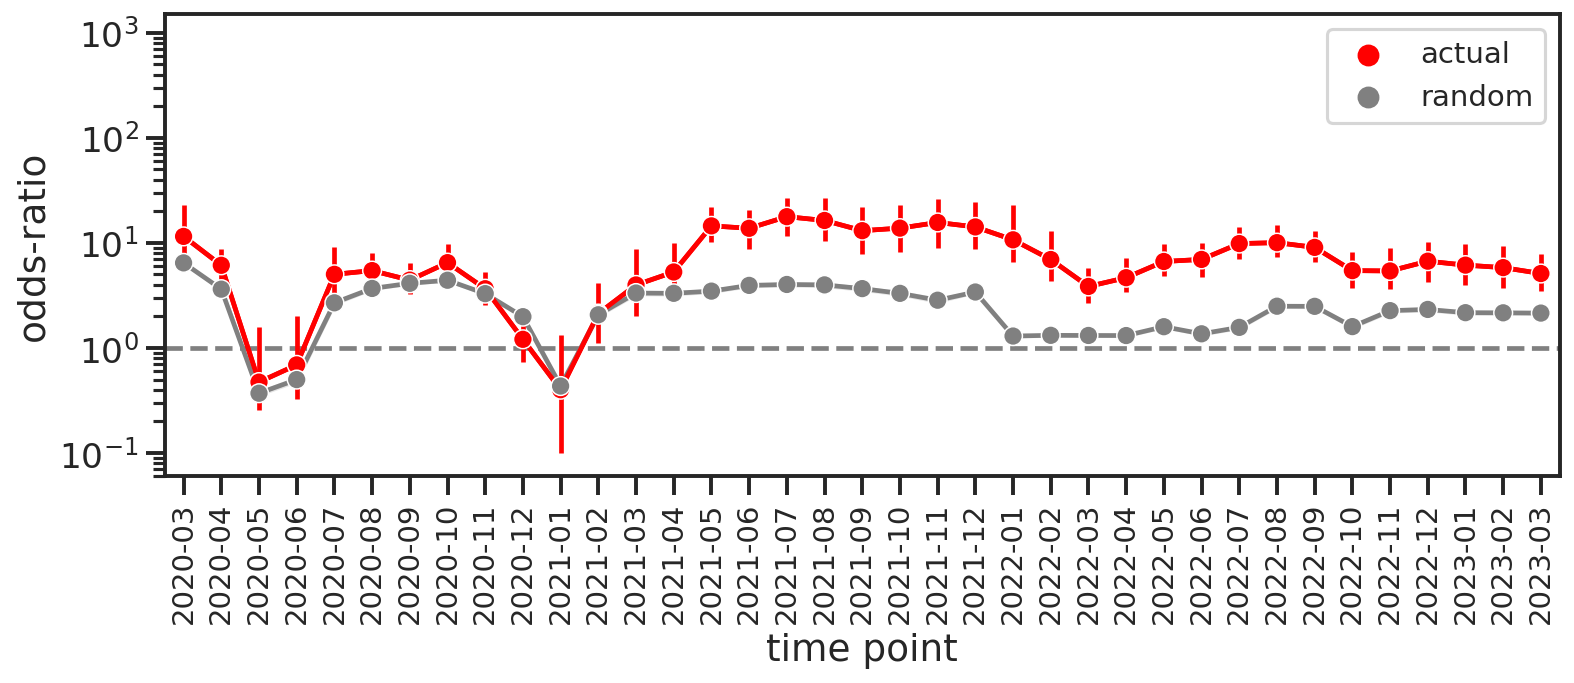

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r,
             x='name',
             y='odds-ratio',
             hue='set',
             errorbar='ci',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
plt.errorbar(range(r['name'].unique().shape[0]),
             r[r['set'] == 'actual']['odds-ratio'],
             yerr=abs(r[r['set'] == 'actual'][['low', 'high']].T.values -
                      r[r['set'] == 'actual']['odds-ratio'].values + 0.1),
             color='r')
sns.scatterplot(data=r.groupby(['name', 'set'])[['odds-ratio']].mean().reset_index(),
                x='name',
                y='odds-ratio',
                hue='set',
                ax=ax,
                palette=['r', 'grey'],
                zorder=10)

plt.axhline(1,
            color='grey', ls='dashed', zorder=-1)

plt.legend(facecolor='w', fontsize=14)

plt.xticks(rotation=90,
           fontsize=14)
plt.xlabel('time point')

plt.xlim(-0.5, r['name'].unique().shape[0] - 0.5)

plt.ylim(0.06, 1500)

plt.yscale('log')

plt.savefig('time_extra_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_extra_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [9]:
res = []
for name in sorted(df['name'].unique()):
    print(name)
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]

    ml = ml_metrics(s,
                    mutated=d_mutated[name],
                    shuffle=False)
    ml['name'] = name
    ml['set'] = 'actual'
    res.append(ml)

    # for i in range(100):
    #     with warnings.catch_warnings():
    #         warnings.simplefilter("ignore")
    #         ml = ml_metrics(s,
    #                         mutated=d_mutated[name],
    #                         shuffle=True)
    #         ml['name'] = name
    #         ml['set'] = 'random'
    #         res.append(ml)

m = pd.concat(res)

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


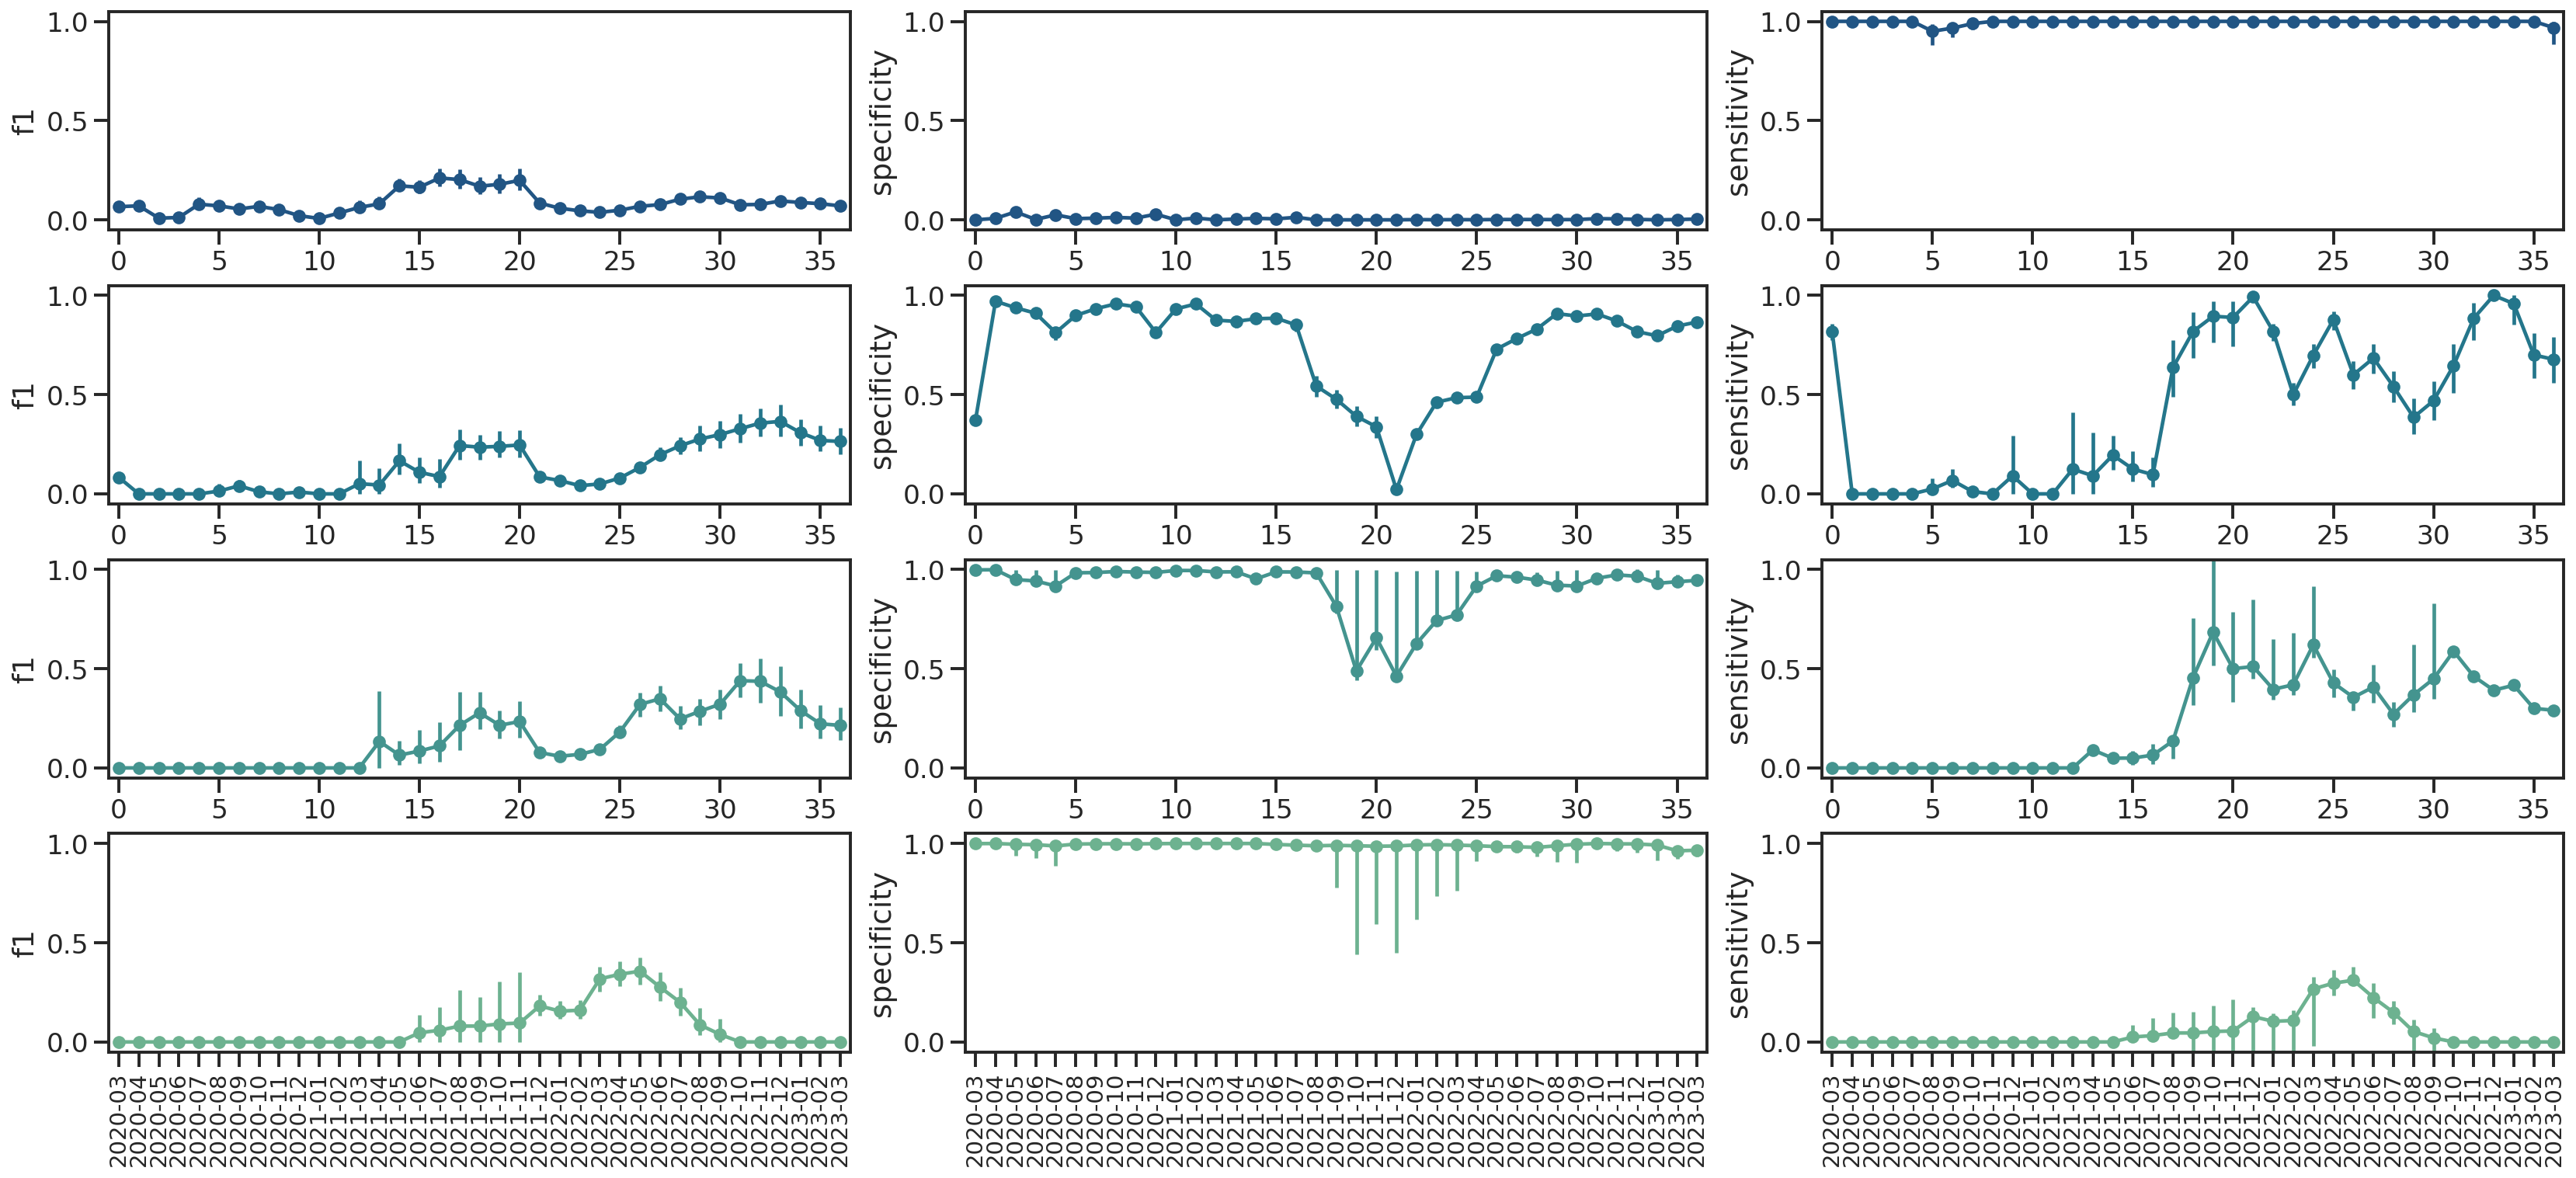

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(22, 10),
                         constrained_layout=True)

for col, metric in zip(range(3),
                       ('f1', 'specificity', 'sensitivity')):
    for row, ol, color in zip(range(4), range(1, 5),
                              sns.color_palette('crest_r', 4)):
        ax = axes[row][col]
        t = m[(m['metric'] == metric) &
              (m['outlier'] == ol)]
        ax.errorbar(range(t['name'].unique().shape[0]),
                    t[t['set'] == 'actual']['value'],
                    yerr=abs(t[t['set'] == 'actual'][['low', 'high']].T.values -
                             t[t['set'] == 'actual']['value'].values),
                    color=color, zorder=-1, fmt='o-',
                    markersize=7)
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel(metric)
        ax.set_xlim(-0.5, m['name'].unique().shape[0] - 0.5)
        if row == 3:
            ax.set_xticks(range(m['name'].unique().shape[0]),
                          labels=m['name'].unique(),
                          rotation=90,
                          fontsize=14)

plt.savefig('time_extra_2.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_extra_2.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [11]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 1)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.066204
2020-04  actual    0.070519
2020-05  actual    0.008559
2020-06  actual    0.011858
2020-07  actual    0.078740
2020-08  actual    0.070370
2020-09  actual    0.054940
2020-10  actual    0.067770
2020-11  actual    0.051466
2020-12  actual    0.020814
2021-01  actual    0.006957
2021-02  actual    0.034783
2021-03  actual    0.062500
2021-04  actual    0.080586
2021-05  actual    0.171190
2021-06  actual    0.164271
2021-07  actual    0.210884
2021-08  actual    0.202765
2021-09  actual    0.169231
2021-10  actual    0.179245
2021-11  actual    0.198895
2021-12  actual    0.084280
2022-01  actual    0.058344
2022-02  actual    0.045406
2022-03  actual    0.037816
2022-04  actual    0.048527
2022-05  actual    0.068130
2022-06  actual    0.076652
2022-07  actual    0.104225
2022-08  actual    0.115972
2022-09  actual    0.110360
2022-10  actual    0.075808
2022-11  actual    0.077728
2022-12  actual    0.095041
2023-01  actual    0.087432
2023

In [12]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 2)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.083535
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.013986
2020-09  actual    0.040816
2020-10  actual    0.010526
2020-11  actual    0.000000
2020-12  actual    0.009479
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.051282
2021-04  actual    0.044444
2021-05  actual    0.166667
2021-06  actual    0.108696
2021-07  actual    0.086957
2021-08  actual    0.243478
2021-09  actual    0.235294
2021-10  actual    0.239437
2021-11  actual    0.246154
2021-12  actual    0.085392
2022-01  actual    0.066897
2022-02  actual    0.041422
2022-03  actual    0.049969
2022-04  actual    0.079814
2022-05  actual    0.133169
2022-06  actual    0.197343
2022-07  actual    0.242424
2022-08  actual    0.276730
2022-09  actual    0.298701
2022-10  actual    0.328358
2022-11  actual    0.356589
2022-12  actual    0.365079
2023-01  actual    0.308725
2023

In [13]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 3)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.000000
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.000000
2020-09  actual    0.000000
2020-10  actual    0.000000
2020-11  actual    0.000000
2020-12  actual    0.000000
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.133333
2021-05  actual    0.064516
2021-06  actual    0.085106
2021-07  actual    0.111111
2021-08  actual    0.214286
2021-09  actual    0.277778
2021-10  actual    0.214876
2021-11  actual    0.233766
2021-12  actual    0.077378
2022-01  actual    0.058795
2022-02  actual    0.068357
2022-03  actual    0.093385
2022-04  actual    0.181425
2022-05  actual    0.320000
2022-06  actual    0.348315
2022-07  actual    0.246914
2022-08  actual    0.285714
2022-09  actual    0.321168
2022-10  actual    0.439560
2022-11  actual    0.436364
2022-12  actual    0.382979
2023-01  actual    0.289855
2023

In [14]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 4)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.000000
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.000000
2020-09  actual    0.000000
2020-10  actual    0.000000
2020-11  actual    0.000000
2020-12  actual    0.000000
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.000000
2021-05  actual    0.000000
2021-06  actual    0.046512
2021-07  actual    0.058824
2021-08  actual    0.080000
2021-09  actual    0.080000
2021-10  actual    0.090909
2021-11  actual    0.095238
2021-12  actual    0.181818
2022-01  actual    0.155340
2022-02  actual    0.160000
2022-03  actual    0.317949
2022-04  actual    0.341176
2022-05  actual    0.356688
2022-06  actual    0.276423
2022-07  actual    0.200000
2022-08  actual    0.085714
2022-09  actual    0.037736
2022-10  actual    0.000000
2022-11  actual    0.000000
2022-12  actual    0.000000
2023-01  actual    0.000000
2023

In [15]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 1)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.000000
2020-04  actual    0.007322
2020-05  actual    0.040055
2020-06  actual    0.001996
2020-07  actual    0.025000
2020-08  actual    0.005952
2020-09  actual    0.008603
2020-10  actual    0.012114
2020-11  actual    0.008755
2020-12  actual    0.028169
2021-01  actual    0.000000
2021-02  actual    0.008929
2021-03  actual    0.000000
2021-04  actual    0.003968
2021-05  actual    0.007500
2021-06  actual    0.004890
2021-07  actual    0.012766
2021-08  actual    0.000000
2021-09  actual    0.000000
2021-10  actual    0.000000
2021-11  actual    0.000000
2021-12  actual    0.000000
2022-01  actual    0.001206
2022-02  actual    0.000321
2022-03  actual    0.001015
2022-04  actual    0.000520
2022-05  actual    0.001622
2022-06  actual    0.001636
2022-07  actual    0.001570
2022-08  actual    0.001149
2022-09  actual    0.001264
2022-10  actual    0.005995
2022-11  actual    0.004839
2022-12  actual    0.002278
2023-01  actual    0.000000
2023

In [16]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 2)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.370539
2020-04  actual    0.970711
2020-05  actual    0.937845
2020-06  actual    0.910180
2020-07  actual    0.812500
2020-08  actual    0.898810
2020-09  actual    0.932692
2020-10  actual    0.957393
2020-11  actual    0.943089
2020-12  actual    0.813146
2021-01  actual    0.931699
2021-02  actual    0.957143
2021-03  actual    0.875000
2021-04  actual    0.869048
2021-05  actual    0.882500
2021-06  actual    0.885086
2021-07  actual    0.851064
2021-08  actual    0.543353
2021-09  actual    0.476852
2021-10  actual    0.390805
2021-11  actual    0.337931
2021-12  actual    0.021540
2022-01  actual    0.299377
2022-02  actual    0.461687
2022-03  actual    0.484684
2022-04  actual    0.487386
2022-05  actual    0.729521
2022-06  actual    0.782443
2022-07  actual    0.830455
2022-08  actual    0.908046
2022-09  actual    0.896334
2022-10  actual    0.906475
2022-11  actual    0.870968
2022-12  actual    0.817768
2023-01  actual    0.796407
2023

In [17]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 3)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.997844
2020-04  actual    0.998431
2020-05  actual    0.948895
2020-06  actual    0.942116
2020-07  actual    0.916667
2020-08  actual    0.983135
2020-09  actual    0.984312
2020-10  actual    0.989557
2020-11  actual    0.986867
2020-12  actual    0.984977
2021-01  actual    0.994746
2021-02  actual    0.994643
2021-03  actual    0.987500
2021-04  actual    0.988095
2021-05  actual    0.952500
2021-06  actual    0.987775
2021-07  actual    0.987234
2021-08  actual    0.982659
2021-09  actual    0.814815
2021-10  actual    0.488506
2021-11  actual    0.655172
2021-12  actual    0.462141
2022-01  actual    0.626281
2022-02  actual    0.742329
2022-03  actual    0.770858
2022-04  actual    0.915995
2022-05  actual    0.968370
2022-06  actual    0.961287
2022-07  actual    0.946625
2022-08  actual    0.920690
2022-09  actual    0.916561
2022-10  actual    0.955635
2022-11  actual    0.972581
2022-12  actual    0.965831
2023-01  actual    0.930140
2023

In [18]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 4)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.999281
2020-04  actual    1.000000
2020-05  actual    0.995856
2020-06  actual    0.994012
2020-07  actual    0.987500
2020-08  actual    0.997024
2020-09  actual    0.998482
2020-10  actual    0.998747
2020-11  actual    0.998124
2020-12  actual    0.999061
2021-01  actual    1.000000
2021-02  actual    1.000000
2021-03  actual    1.000000
2021-04  actual    1.000000
2021-05  actual    1.000000
2021-06  actual    0.995110
2021-07  actual    0.991489
2021-08  actual    0.988439
2021-09  actual    0.990741
2021-10  actual    0.988506
2021-11  actual    0.986207
2021-12  actual    0.987272
2022-01  actual    0.992767
2022-02  actual    0.994217
2022-03  actual    0.991877
2022-04  actual    0.988817
2022-05  actual    0.984185
2022-06  actual    0.983642
2022-07  actual    0.980377
2022-08  actual    0.988506
2022-09  actual    0.996207
2022-10  actual    1.000000
2022-11  actual    0.998387
2022-12  actual    0.997722
2023-01  actual    0.992016
2023

In [19]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 1)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    1.000000
2020-04  actual    1.000000
2020-05  actual    1.000000
2020-06  actual    1.000000
2020-07  actual    1.000000
2020-08  actual    0.950000
2020-09  actual    0.966102
2020-10  actual    0.988506
2020-11  actual    1.000000
2020-12  actual    1.000000
2021-01  actual    1.000000
2021-02  actual    1.000000
2021-03  actual    1.000000
2021-04  actual    1.000000
2021-05  actual    1.000000
2021-06  actual    1.000000
2021-07  actual    1.000000
2021-08  actual    1.000000
2021-09  actual    1.000000
2021-10  actual    1.000000
2021-11  actual    1.000000
2021-12  actual    1.000000
2022-01  actual    1.000000
2022-02  actual    1.000000
2022-03  actual    1.000000
2022-04  actual    1.000000
2022-05  actual    1.000000
2022-06  actual    1.000000
2022-07  actual    1.000000
2022-08  actual    1.000000
2022-09  actual    1.000000
2022-10  actual    1.000000
2022-11  actual    1.000000
2022-12  actual    1.000000
2023-01  actual    1.000000
2023

In [20]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 2)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.817568
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.025000
2020-09  actual    0.067797
2020-10  actual    0.011494
2020-11  actual    0.000000
2020-12  actual    0.090909
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.125000
2021-04  actual    0.090909
2021-05  actual    0.195122
2021-06  actual    0.125000
2021-07  actual    0.096774
2021-08  actual    0.636364
2021-09  actual    0.818182
2021-10  actual    0.894737
2021-11  actual    0.888889
2021-12  actual    0.992908
2022-01  actual    0.818182
2022-02  actual    0.500000
2022-03  actual    0.698276
2022-04  actual    0.877551
2022-05  actual    0.600000
2022-06  actual    0.684211
2022-07  actual    0.540541
2022-08  actual    0.385965
2022-09  actual    0.469388
2022-10  actual    0.647059
2022-11  actual    0.884615
2022-12  actual    1.000000
2023-01  actual    0.958333
2023

In [21]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 3)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.000000
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.000000
2020-09  actual    0.000000
2020-10  actual    0.000000
2020-11  actual    0.000000
2020-12  actual    0.000000
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.090909
2021-05  actual    0.048780
2021-06  actual    0.050000
2021-07  actual    0.064516
2021-08  actual    0.136364
2021-09  actual    0.454545
2021-10  actual    0.684211
2021-11  actual    0.500000
2021-12  actual    0.510638
2022-01  actual    0.396104
2022-02  actual    0.418919
2022-03  actual    0.620690
2022-04  actual    0.428571
2022-05  actual    0.355556
2022-06  actual    0.407895
2022-07  actual    0.270270
2022-08  actual    0.368421
2022-09  actual    0.448980
2022-10  actual    0.588235
2022-11  actual    0.461538
2022-12  actual    0.391304
2023-01  actual    0.416667
2023

In [22]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 4)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.000000
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.000000
2020-09  actual    0.000000
2020-10  actual    0.000000
2020-11  actual    0.000000
2020-12  actual    0.000000
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.000000
2021-05  actual    0.000000
2021-06  actual    0.025000
2021-07  actual    0.032258
2021-08  actual    0.045455
2021-09  actual    0.045455
2021-10  actual    0.052632
2021-11  actual    0.055556
2021-12  actual    0.127660
2022-01  actual    0.103896
2022-02  actual    0.108108
2022-03  actual    0.267241
2022-04  actual    0.295918
2022-05  actual    0.311111
2022-06  actual    0.223684
2022-07  actual    0.148649
2022-08  actual    0.052632
2022-09  actual    0.020408
2022-10  actual    0.000000
2022-11  actual    0.000000
2022-12  actual    0.000000
2023-01  actual    0.000000
2023